## Todo
- Undersampling
- Cross Validation
- Data Exploration

In [15]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import zipfile

In [2]:
z = zipfile.ZipFile('train.csv.zip')
df = pd.read_csv(z.open('train.csv'))

## Exploration

In [92]:
constants = []
for col in df.columns:
    if df[col].std() == 0:
        constants.append(col)
df.drop(constants, axis=1, inplace=True)

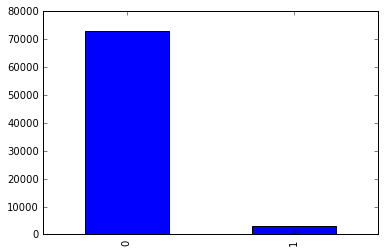

In [29]:
df.TARGET.value_counts().plot(kind='bar')

In [55]:
num_positive = len(df[df['TARGET'] == 1])
num_negative = len(df) - num_positive
print num_positive / float(num_negative)

0.0411987070619


### Undersampling Majority Class

In [93]:
df_positive = df[df['TARGET'] == 1]
df_negative = df[df['TARGET'] == 0].sample(frac=num_positive / float(num_negative))

In [94]:
ndf = pd.concat([df_positive, df_negative])

In [95]:
x = ndf.drop(['ID', 'TARGET'], axis=1)
y = ndf['TARGET']

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

In [99]:
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=16, oob_score=True)
cv = cross_validation.StratifiedKFold(y, n_folds=4, shuffle=True)
scores = cross_validation.cross_val_score(rfc, x, y, cv=cv, scoring='roc_auc')
print("Auc: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
rfc.fit(x, y)

Auc: 0.829 (+/- 0.013)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [68]:
from sklearn.metrics import roc_auc_score
print('Overall AUC:', roc_auc_score(y, rfc.predict_proba(x)[:,1]))

('Overall AUC:', 0.99776720191192281)


In [12]:
feat_imp = pd.Series(rfc.feature_importances_, index=x.columns)
feat_imp.sort_values(inplace=True, ascending=False)

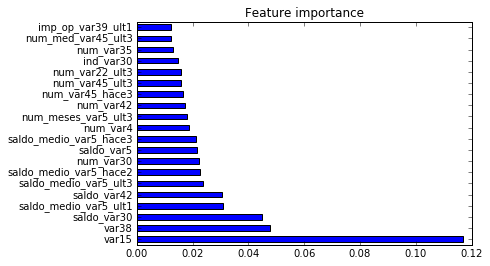

In [17]:
feat_imp.head(20).plot(kind='barh', title='Feature importance')

In [33]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [34]:
lr.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Submission

In [37]:
import datetime

In [50]:
def export_predictions(model, method, num=1):
    test = pandas.read_csv(zipfile.ZipFile('test.csv.zip').open('test.csv'))
    id_test = test['ID']
    x_test = test.drop(['ID'], axis=1)
    y_pred = model.predict_proba(x_test)
    sub = pandas.DataFrame({'ID': id_test, 'TARGET': y_pred[:,1]})
    filename = 'submission_{date}#{num}_{method}.csv'.format(date=datetime.date.today().isoformat(), num=num, method=method)
    sub.to_csv(filename, index=False)

In [90]:
export_predictions(rfc, 'rfc-undersampling-tuned', 4)